In [6]:
%load_ext autoreload
%autoreload 2
%reset -f

import torch
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import sys
import os
import subprocess
subprocess.run(["rm", "-rf", "__pycache__"])
# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
# sys.path.append(parent_dir)


import src.visualisation as vis
from src.StocksDataset import StocksDataset
from src.EarlyStopping import EarlyStopping
from models.LSTM import LSTM
from src.DataPreprocessor import DataPreprocessor
from src.Testing import Testing
from src import loss_functions

torch.manual_seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
path = "./datasets/aapl.csv"
train_split_part = 0.8
lookback_days = 30
future_days = 5

data_preprocessor = DataPreprocessor(path)
scalers = data_preprocessor.z_score(cols_to_standardize=["Open", "High", "Low", "Close", "Volume"], train_split_part=train_split_part)
x, y = data_preprocessor.split_data(
    context_size=lookback_days,
    future_size=future_days,
    train_features=["Open", "High", "Low", "Close", "Volume"],
    features_to_predict=["Close"]
)
print(x.shape, y.shape)

(2484, 30, 5) (2484, 1, 1)


In [8]:
n = len(x)
split = int(0.8 * n)

train_dataset = StocksDataset(x[:split], y[:split])
test_dataset  = StocksDataset(x[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

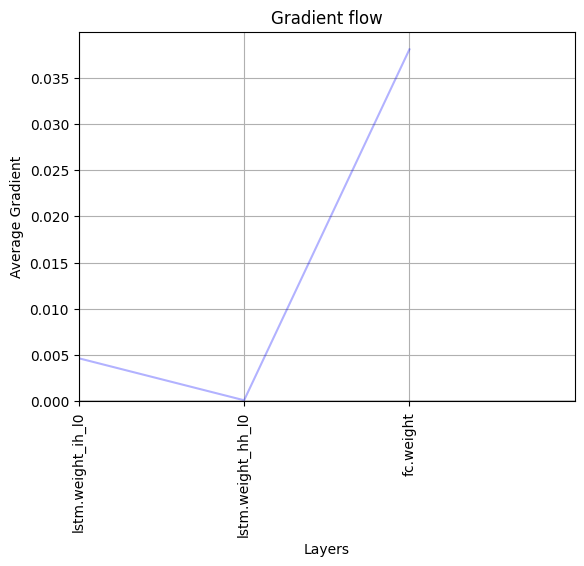

Epoch [5/20], Train loss: 0.006006, Validation loss: 0.058500
Epoch [10/20], Train loss: 0.004883, Validation loss: 0.010204
Epoch [15/20], Train loss: 0.004805, Validation loss: 0.011371
Best loss: 0.010203889047261328


/var/folders/5p/j_fhqr1s4_n5j3pcfgd1r2040000gn/T/ipykernel_81717/2782170395.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weig

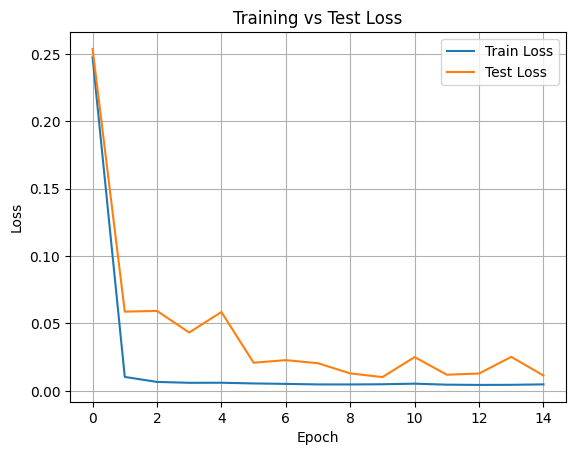

In [9]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

n_epochs = 20
plot_gradients = True

model = LSTM(
    input_size=5,
    hidden_size=512,
    num_layers=1,
    dropout=0.0,
    pred_days=future_days
).to(device)

criterion = nn.MSELoss()
#criterion = loss_functions.directional_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses = []
test_losses = []
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(n_epochs):
    # ---- Train ----
    model.train()
    total_loss = 0
    _batch_counter = 0 # used to show gradients only once
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        loss.backward()

        if epoch == 0 and plot_gradients and _batch_counter == 0:
            vis.plot_grad_flow(model.named_parameters())

        optimizer.step()
        _batch_counter += 1

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step()

    # ---- Test ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {avg_train_loss:.6f}, Validation loss: {avg_val_loss:.6f}")

    # ---- Early stopping ----
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print(f"Best loss: {early_stopping.best_loss}")
        model.load_state_dict(torch.load("model_weights.pt"))  # restore best weights
        break


vis.plot_losses(train_losses, test_losses)

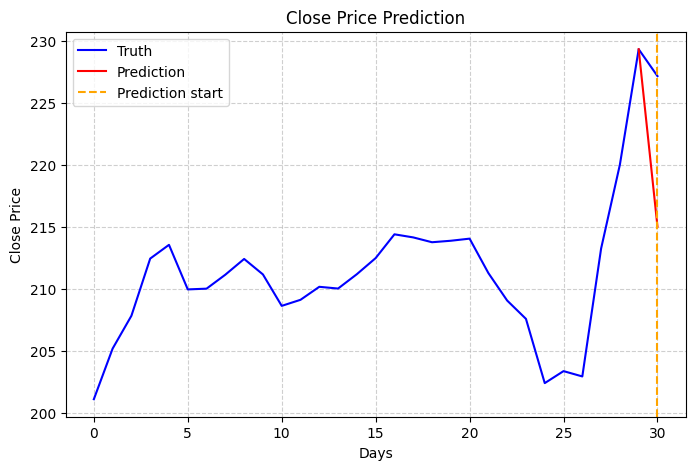

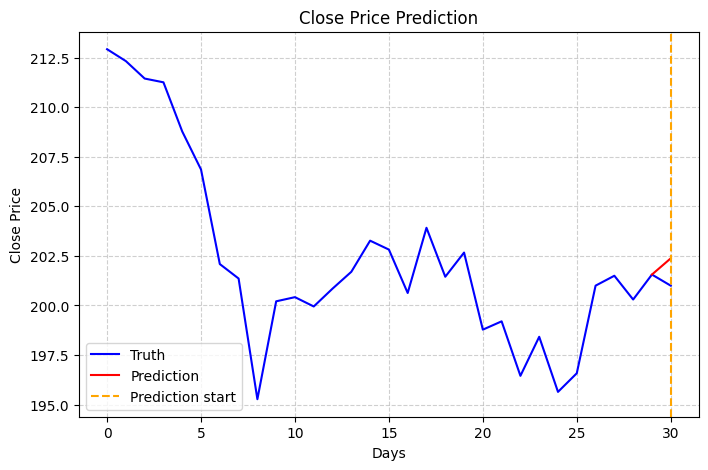

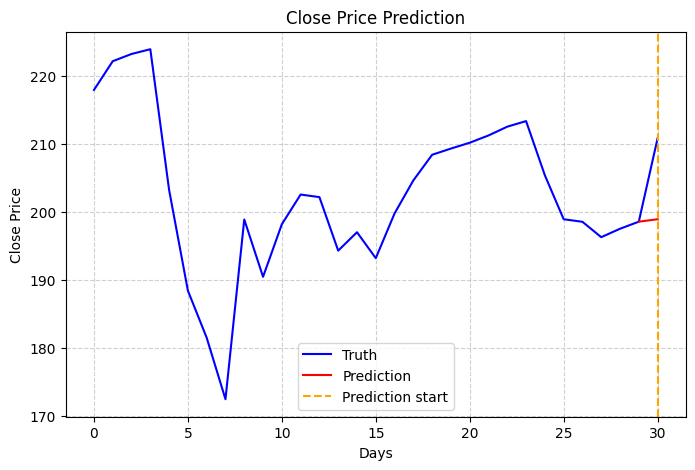

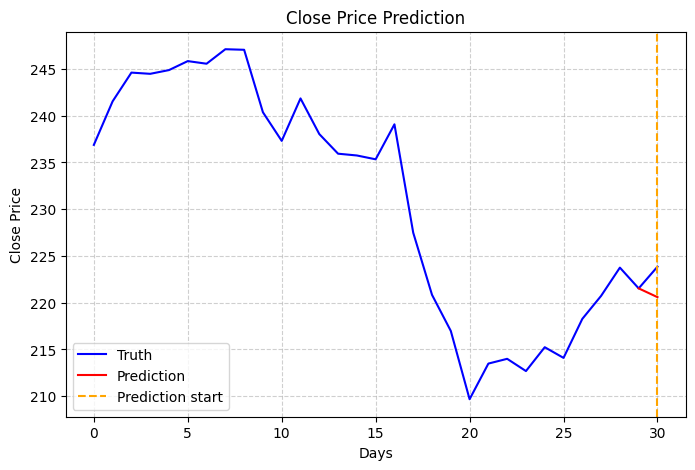

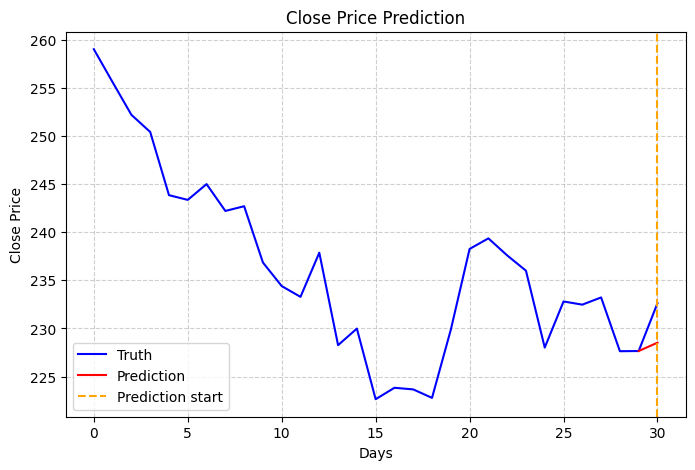

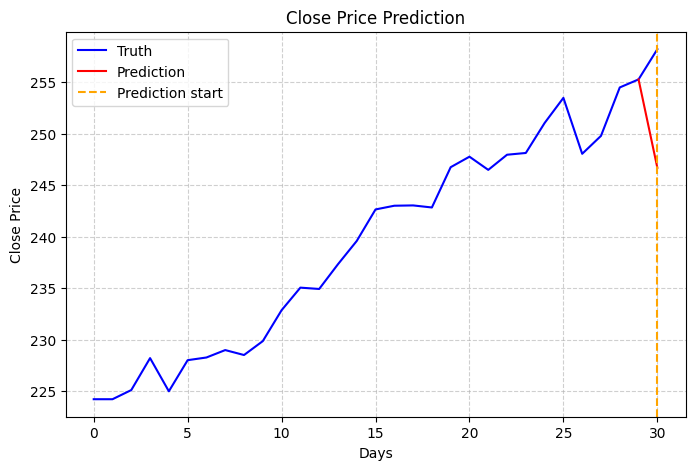

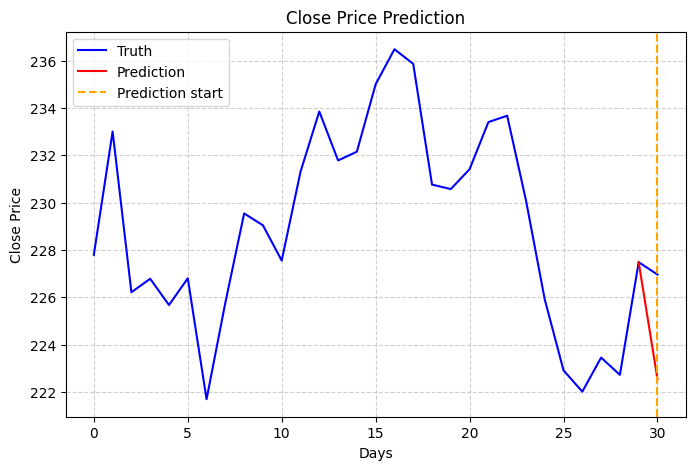

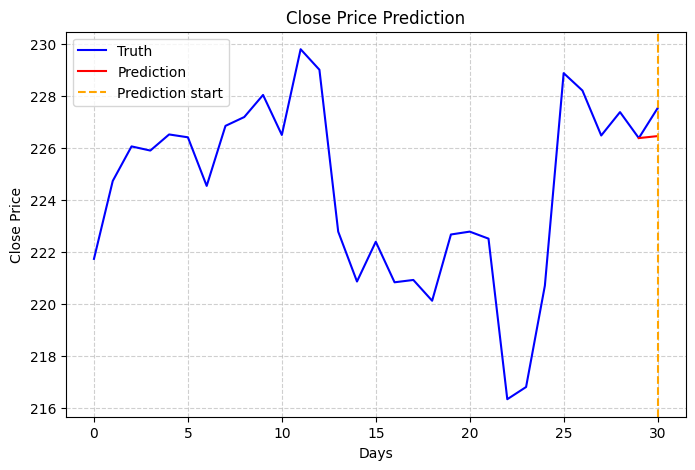

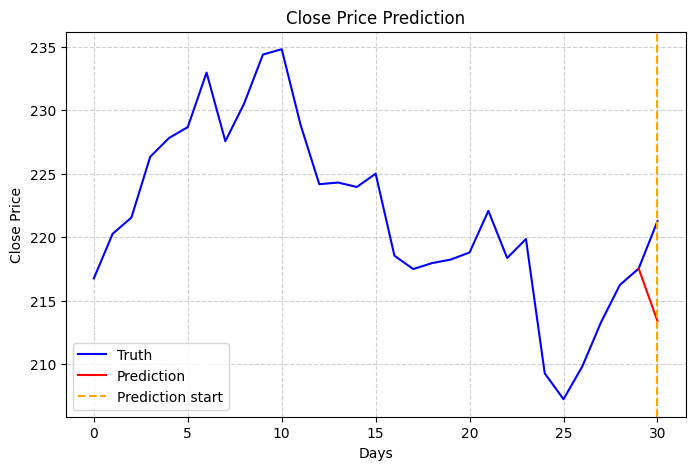

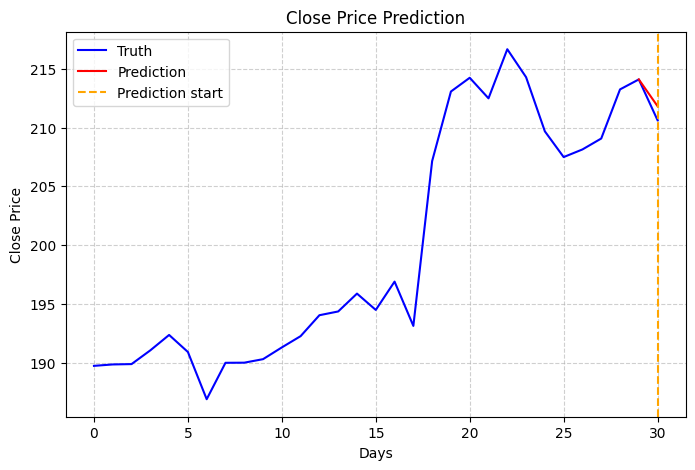

In [10]:
testing = Testing(model, device)
testing.get_n_last_prediction_windows(data_preprocessor.data_np, 10, lookback_days, future_days, scalers, "Close", save_to_examples=False)